# 2) Custom Inference
The previous notebook, `1-simple-inference.ipynb` showed how to quickly run inference with the `pitchfork_sampler` default setup.

In reality, we can tune parts of the sampling pipeline described in the paper, which I'll split into three parts:
1. Priors
2. `UltraNest` parameters
3. Surface term GP parameters

By default, `pitchfork_sampler` will use:
1. The priors used in the paper, which are bounded to the trained ranges of `pitchfork`
2. The `UltraNest` defaults (with the exception of `ndraw_min` and `ndraw_max`, which we'll get to later)
3. The GP variance and lengthscale factor used in the paper for sampling Solar fundamental properties (`gp_var = 4` and `gp_ls_factor=7`, respectively).

In many cases, these defaults should work well (and are safe!). Regardless, here I'll show you how to customise some of these properties if, for instance, you want to restrict your priors for a given star, or turn down `ndraw_max` so the sampler doesn't OOM your laptop.

We'll start with **1. Priors**.

In [8]:
import numpy as np
import json
import corner
import matplotlib.pyplot as plt

from scripts import pitchfork_compile, pitchfork_sampler, posterior_plot

### compile pitchfork

with open('pitchfork/pitchfork.json', 'r') as fp:
    pitchfork_dict = json.load(fp)

with open('pitchfork/pitchfork_info.json', 'r') as fp:
    pitchfork_info = json.load(fp)

pitchfork_cov = np.loadtxt('pitchfork/pitchfork_covariance.txt')

pitchfork = pitchfork_compile(pitchfork_dict, pitchfork_info)

## 1. Priors
Before, we initialised the sampler without specifying our prior beforehand which means we fall back to the default priors use in the paper:

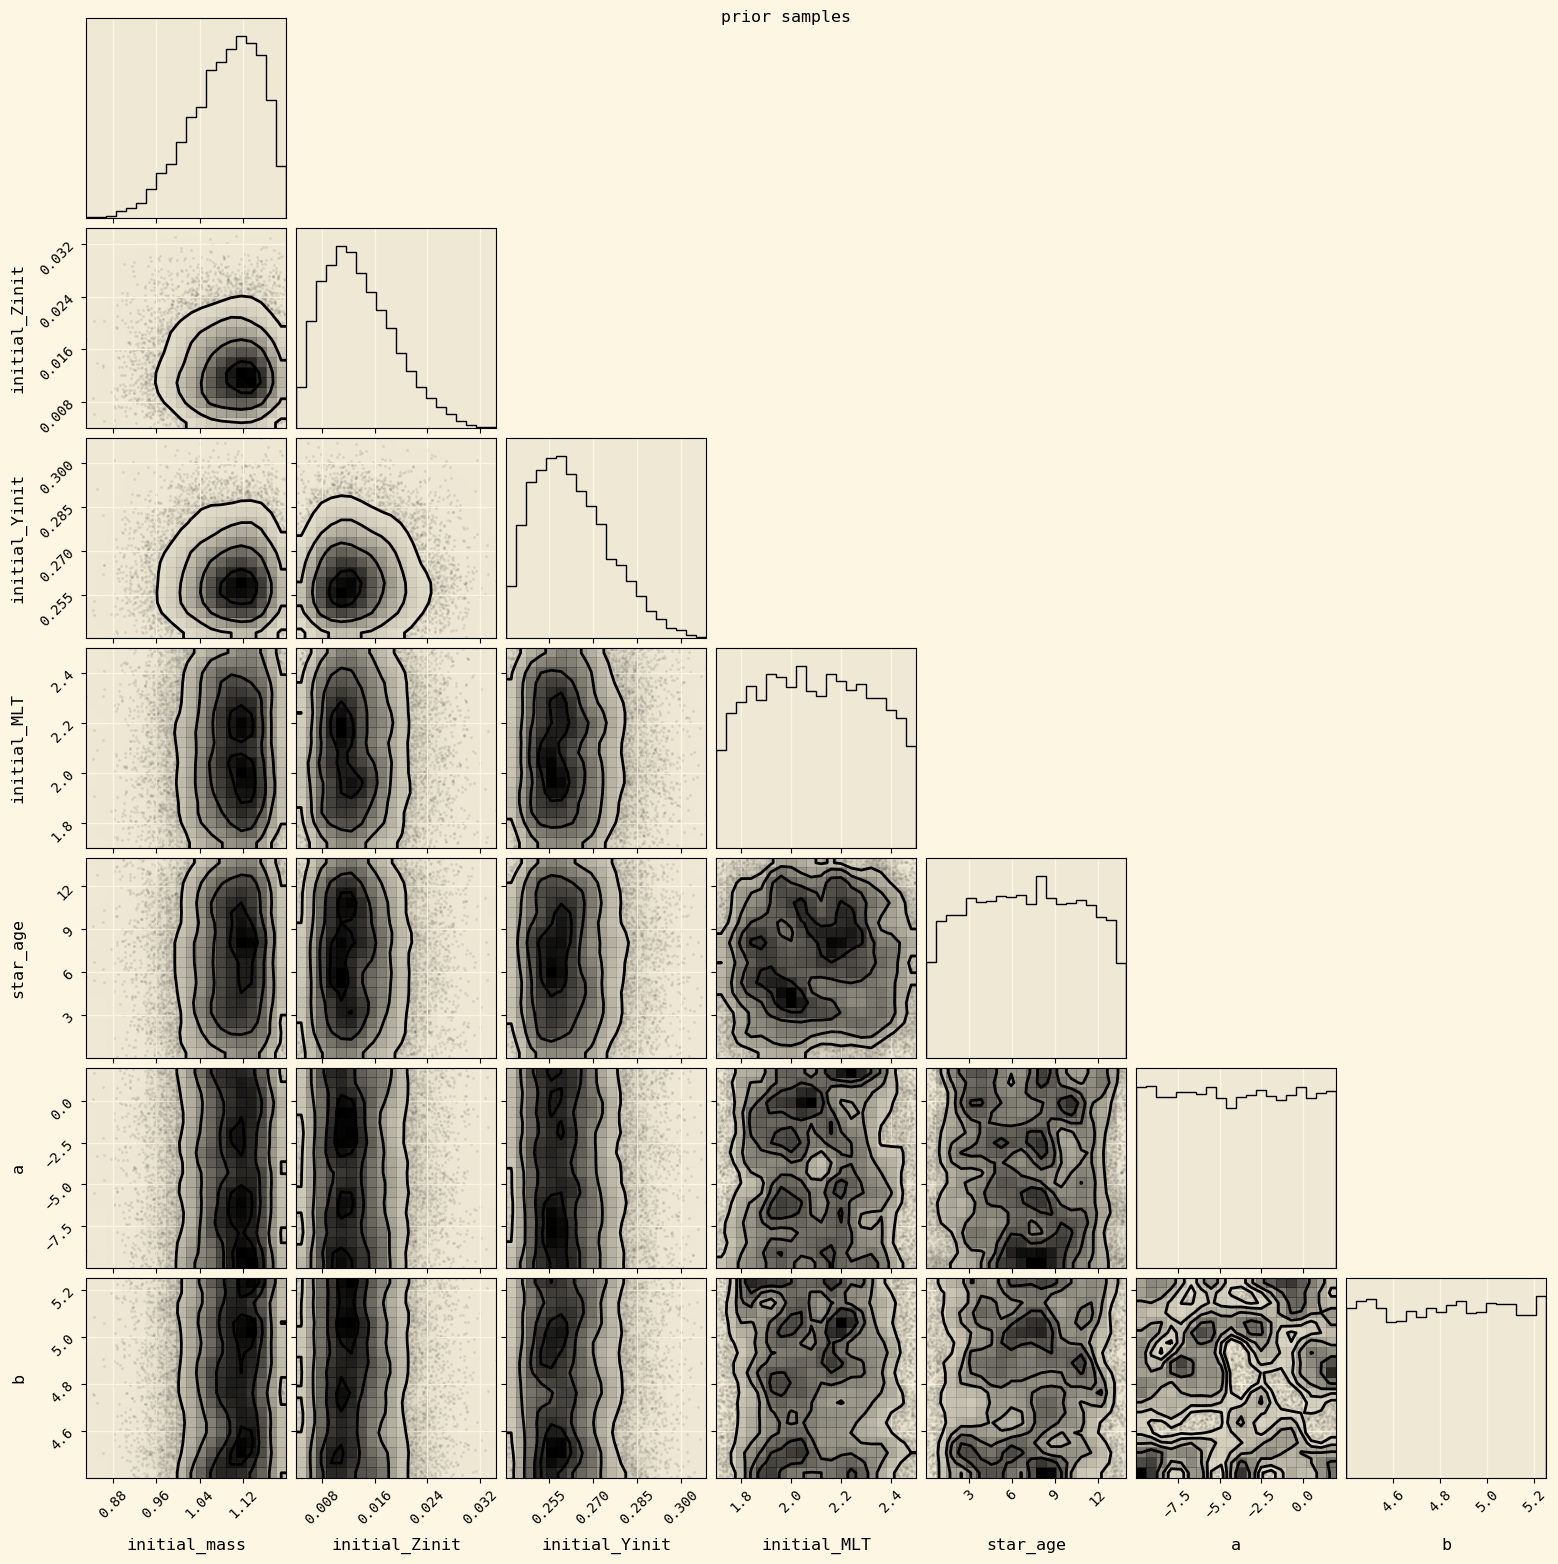

In [4]:
sampler = pitchfork_sampler(pitchfork, pitchfork_cov)

priors = sampler.priors

labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

size = 10000
prior_samples = np.array([prior.rvs(size=size) for prior in priors])

corner.corner(prior_samples.T, color='black', labels = labels, hist_kwargs={'density':True}, smooth=True);
plt.suptitle('prior samples')
plt.show()

I leave these as defaults partly because they'll work fine in many cases, but much more importantly:

**!!! NEURAL NETWORKS DO SILLY THINGS OUTSIDE THE BOUNDS OF THEIR TRAINING DATA - YOU HAVE BEEN WARNED !!!**

Read the paper to find out more, but in short - these priors were chosen specifically to stop `pitchfork` from being asked to predict for inputs that fall outside of the trained range of the grid.

Outside of this trained range, interpolation becomes extrapolation. `pitchfork` will start making wacky predictions (I'm talking $L_\text{pred}=1\times10^{64}\,L_{\odot}$, $T_\text{pred}=1\times10^{-6}\,\text{K}$ levels of wacky) that are in no way represented by the summary statistic for `pitchfork` precision that we use to define the likelihood function.

That being said, it's fine to *restrict* the prior ranges to within the trained range of `pitchfork` if you need to, or change the functional form of the priors. Also, given that `pitchfork` is only trained on the fundamental properties (`initial_mass`, `initial_Zinit`, `initial_Yinit`, `initial_MLT`, `star_age`) you're free to change the ranges on the surface term parameters `a` and `b` as much as you like.

I've included some helper functions in `utils.py` for making beta and uniform priors like we do in the paper - I recommend sticking to these because you can specify hard limits for the prior to avoid `pitchfork` extrapolation, but feel free to restrict the range or mess with the shape parameters:

In [21]:
from scripts import beta_prior, uniform_prior
# beta_prior(min, max, a, b)
# uniform_prior(min, max)

mass_prior = uniform_prior(0.95, 1.05) #<- default: beta_prior(0.8, 1.2, a=5, b=2)

Zinit_prior = uniform_prior(0.008, 0.02) #<- default: beta_prior(0.004, 0.038, a=2, b=5)

Yinit_prior = uniform_prior(0.25, 0.28) #<- default: beta_prior(0.24, 0.32, a=2, b=5)

MLT_prior = uniform_prior(2.1, 2.2) #<- default: beta_prior(1.7, 2.5, a=1.2, b=1.2)

age_prior = uniform_prior(2, 6) #<- default: beta_prior(0.03, 14, a=1.2, b=1.2)

a_prior = uniform_prior(-4, 0) #<- default: uniform_prior(-10, 2)

b_prior = uniform_prior(3.8, 5.5) #<- default: uniform_prior(4.4, 5.25)

custom_priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior, a_prior, b_prior]

Having defined our custom priors, we just pass them to the `pitchfork_sampler` object along with `pitchfork` when initialising and then we can sample and plot as before:

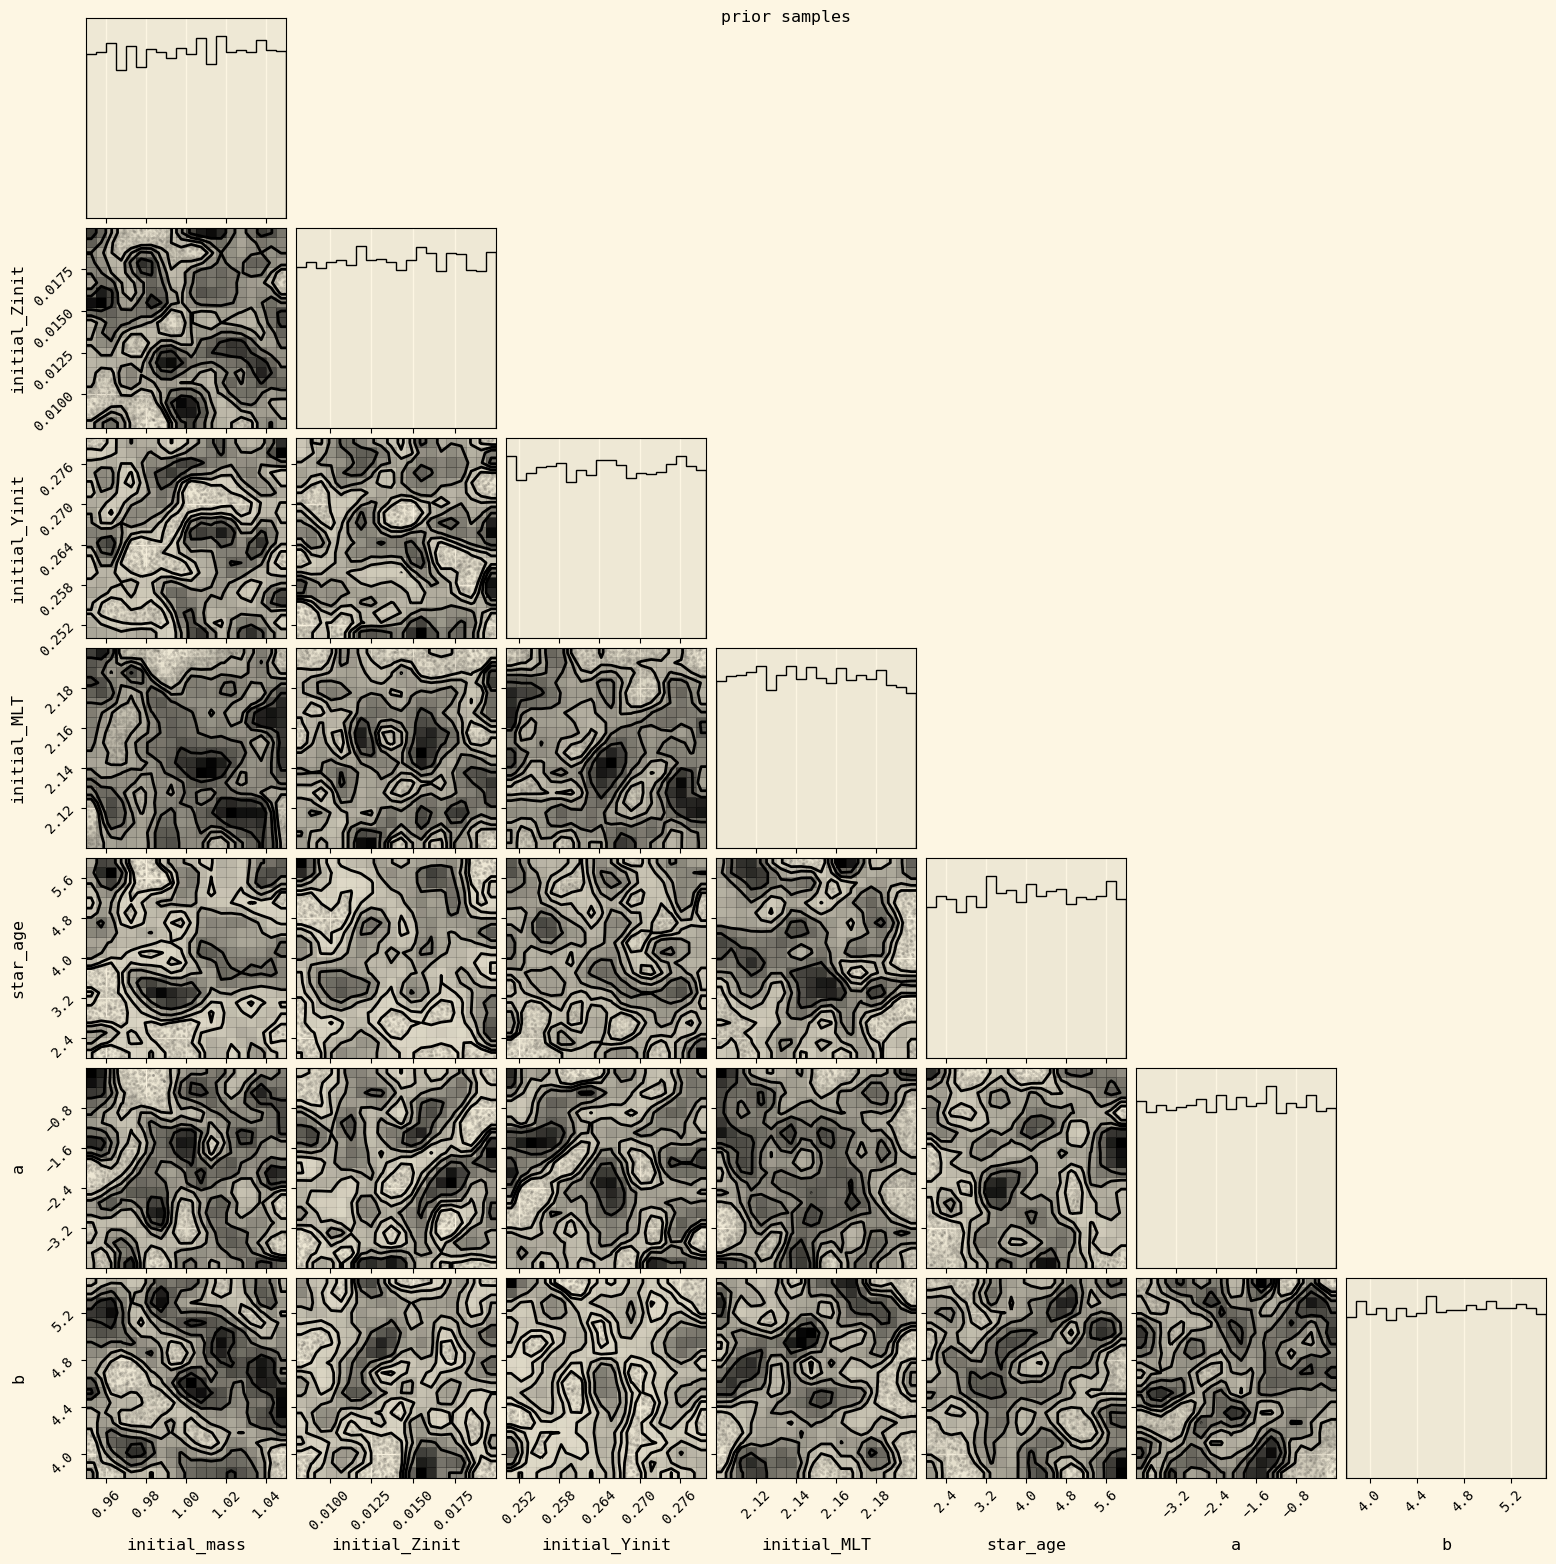

In [22]:
sampler = pitchfork_sampler(pitchfork, pitchfork_cov, priors=custom_priors)

priors = sampler.priors

labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

size = 10000
prior_samples = np.array([prior.rvs(size=size) for prior in priors])

corner.corner(prior_samples.T, color='black', labels = labels, hist_kwargs={'density':True}, smooth=True);
plt.suptitle('prior samples')
plt.show()

Funky! But fine for `pitchfork` :)

Let's see how a nested sampling run using these priors looks for the sun:

[pitchfork_sampler] sampling posterior of Sun...
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2  63 [-1.9737..-1.9735]*| it/evals=6280/71995 eff=8.7716% N=400           0 0  
[ultranest] Likelihood function evaluations: 71995
[ultranest]   logZ = -12.98 +- 0.1018
[ultranest] Effective samples strategy satisfied (ESS = 2123.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.01 total:0.10 required:<0.50
[ultranest] done iterating.
[pitchfork_sampler] finished in 10.6s!


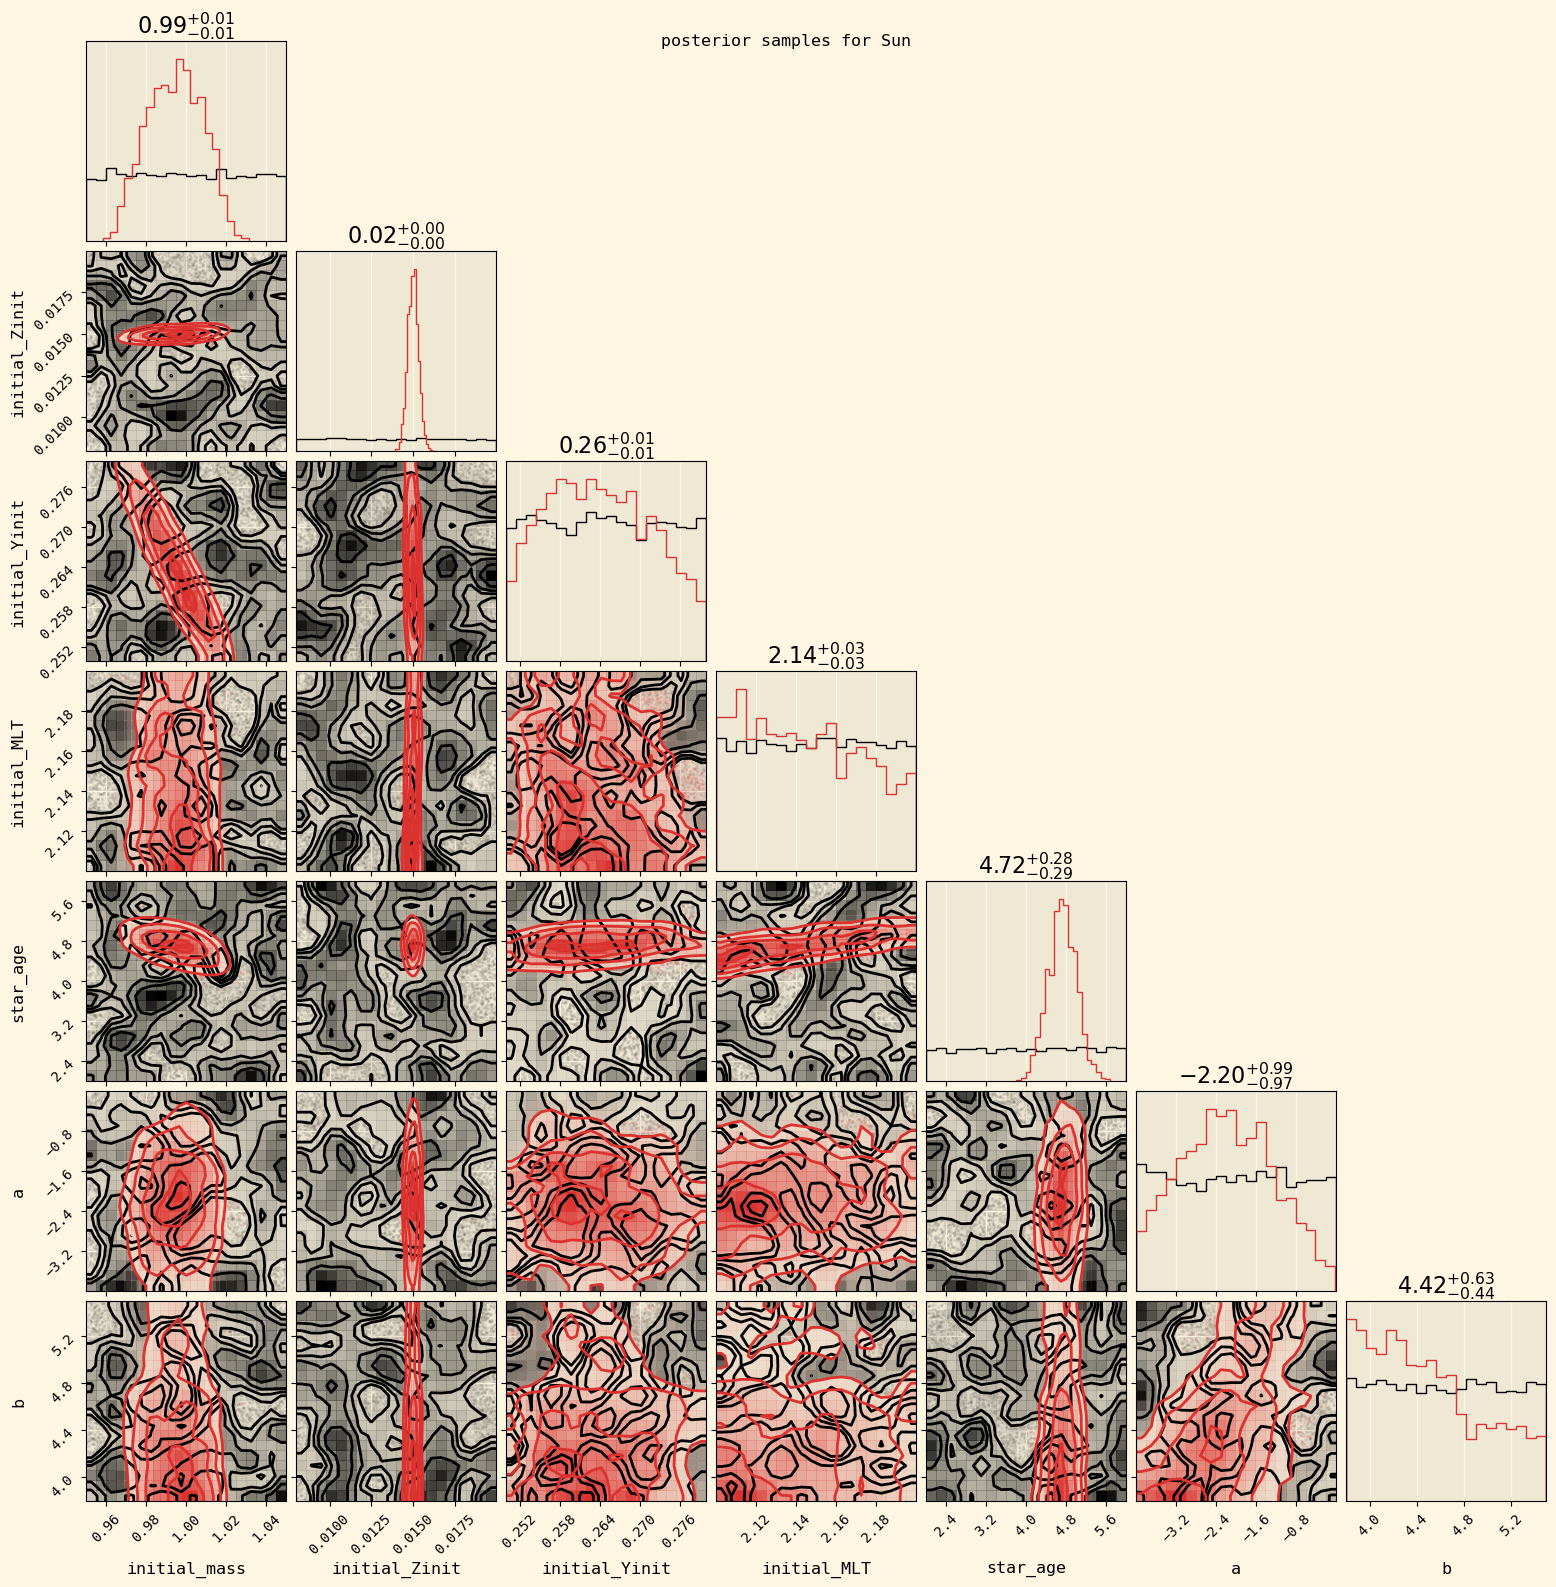

In [25]:
star_name = 'Sun'

results = sampler(star_name)

posterior_plot(results, include_prior=True, star_name=star_name);

## 2. UltraNest parameters
There are several parameters that we can tune within `UltraNest` that can change how our sampler behaves. I won't go into too much detail on what these actually do here - you can find that in the [docs](https://johannesbuchner.github.io/UltraNest/index.html).

`pitchfork_sampler` will just use the `UltraNest` defaults for most of these, which will work well in many cases (but I'll show you how to tweak some of these later).

The only ones that aren't the `UltraNest` defaults are `ndraw_min` and `ndraw_max`.

### 2.1. `ndraw_min` and `ndraw_max`
These parameters control the number of points that are proposed simultaneously by the sampler to be evaluated via the likelihood function.

`UltraNest` starts by drawing at `ndraw_max`, and then will dynamically reduce the number of draws if the efficiency (see `eff` value in `UltraNest` readout) drops, to a lower limit of `ndraw_min`.

The defaults are `ndraw_min=128` and `ndraw_max=65536`. The [docs](https://johannesbuchner.github.io/UltraNest/index.html) says for both of these parameters to "*Increase this if your likelihood makes vectorization very cheap*".

**Our `pitchfork` likelihood makes vectorisation *very* cheap.**

Therefore, I set the defaults to `ndraw_min=1024` and `ndraw_max=524288`.

Even though `Ultranest` will rapidly drop from `ndraw_max` in a few iterations, it may be that these defaults are too intense for your machine. In that case, we can easily reduce like so:

In [52]:
sampler = pitchfork_sampler(pitchfork, pitchfork_cov)

results = sampler('Sun',ndraw_min=512, ndraw_max=262144)

[pitchfork_sampler] sampling posterior of Sun...
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2  81 [-2.2803..-2.2801]*| it/evals=8280/141302 eff=5.8764% N=400   0    0      0 
[ultranest] Likelihood function evaluations: 141766
[ultranest]   logZ = -18.25 +- 0.1279
[ultranest] Effective samples strategy satisfied (ESS = 2350.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.
[pitchfork_sampler] finished in 1m 41.0s!


This should still be reasonably fast, and may even be faster than the defaults if your machine was struggling with memory bottlenecks before.

I'd avoid setting both `ndraw_min` and `ndraw_max` to high values, because the final stages of nested sampling take many many iterations in a small area of parameter space, within which making many draws is completely unneccassary (which is why `UltraNest` dynamically reduces the number of draws). It's best to have a wide range, like shown above.

### 2.2. `frac_remain`
Another `UltraNest` parameter which might come in handy is `frac_remain`, which defines the fraction of the integral left in the remainder at which `UltraNest` should stop sampling.

I've left this at the default, `frac_remain=0.01`, which works well in many cases (the [docs](https://johannesbuchner.github.io/UltraNest/index.html) say that a higher number, like 0.5, is fine if we know the posterior is simple - which we'd expect for solar-like oscillators).

However, there are a couple reasons why you might want to change this - for instance, if you're bugfixing and don't necessarily care about the sampler meaningfully constraining the posterior, you might want to set the `frac_remain` very high like so:

In [46]:
sampler = pitchfork_sampler(pitchfork, pitchfork_cov)

results = sampler('Sun',frac_remain=0.5)

[pitchfork_sampler] sampling posterior of Sun...
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2  00 [-4.2453..-4.2429]*| it/evals=6040/129988 eff=4.6609% N=400 0      0      0  
[ultranest] Likelihood function evaluations: 130382
[ultranest]   logZ = -17.96 +- 0.1421
[ultranest] Effective samples strategy satisfied (ESS = 905.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.43, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.14 tail:0.41 total:0.43 required:<0.50
[ultranest] done iterating.
[pitchfork_sampler] finished in 1m 1.1s!


Fast!

Or, if you'd like to make sure you've **really** found those peaks, you could set this very low (which may take quite a bit longer):

In [50]:
sampler = pitchfork_sampler(pitchfork, pitchfork_cov)

results = sampler('Sun',frac_remain=1e-5)

[pitchfork_sampler] sampling posterior of Sun...
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2  .71 [-1.7932..-1.7784] | it/evals=11259/223213 eff=5.0531% N=400      0      0 
[ultranest] Likelihood function evaluations: 223213
[ultranest]   logZ = -17.9 +- 0.1375
[ultranest] Effective samples strategy satisfied (ESS = 2310.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.14 tail:0.00 total:0.14 required:<0.50
[ultranest] done iterating.
[pitchfork_sampler] finished in 1m 50.5s!


### 2.3. `min_num_live_points`

In [53]:
sampler = pitchfork_sampler(pitchfork, pitchfork_cov)

results = sampler('Sun', ndraw_min=1024, ndraw_max=524288)

[pitchfork_sampler] sampling posterior of Sun...
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2  83 [-2.2713..-2.2712]*| it/evals=8284/143618 eff=5.7842% N=400    0   0      0  
[ultranest] Likelihood function evaluations: 143618
[ultranest]   logZ = -18.27 +- 0.1453
[ultranest] Effective samples strategy satisfied (ESS = 2408.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
[pitchfork_sampler] finished in 1m 15.6s!


In [60]:
sampler = pitchfork_sampler(pitchfork, pitchfork_cov)

results = sampler('Sun', ndraw_min=1024, ndraw_max=524288, min_num_live_points = 200)

[pitchfork_sampler] sampling posterior of Sun...
[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-2  79 [-2.2528..-2.2525]*| it/evals=4050/72909 eff=5.5701% N=200        00  0    0 
[ultranest] Likelihood function evaluations: 72952
[ultranest]   logZ = -17.79 +- 0.1857
[ultranest] Effective samples strategy satisfied (ESS = 1197.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.19, need <0.5)
[ultranest]   logZ error budget: single: 0.26 bs:0.19 tail:0.01 total:0.19 required:<0.50
[ultranest] done iterating.
[pitchfork_sampler] finished in 27.1s!


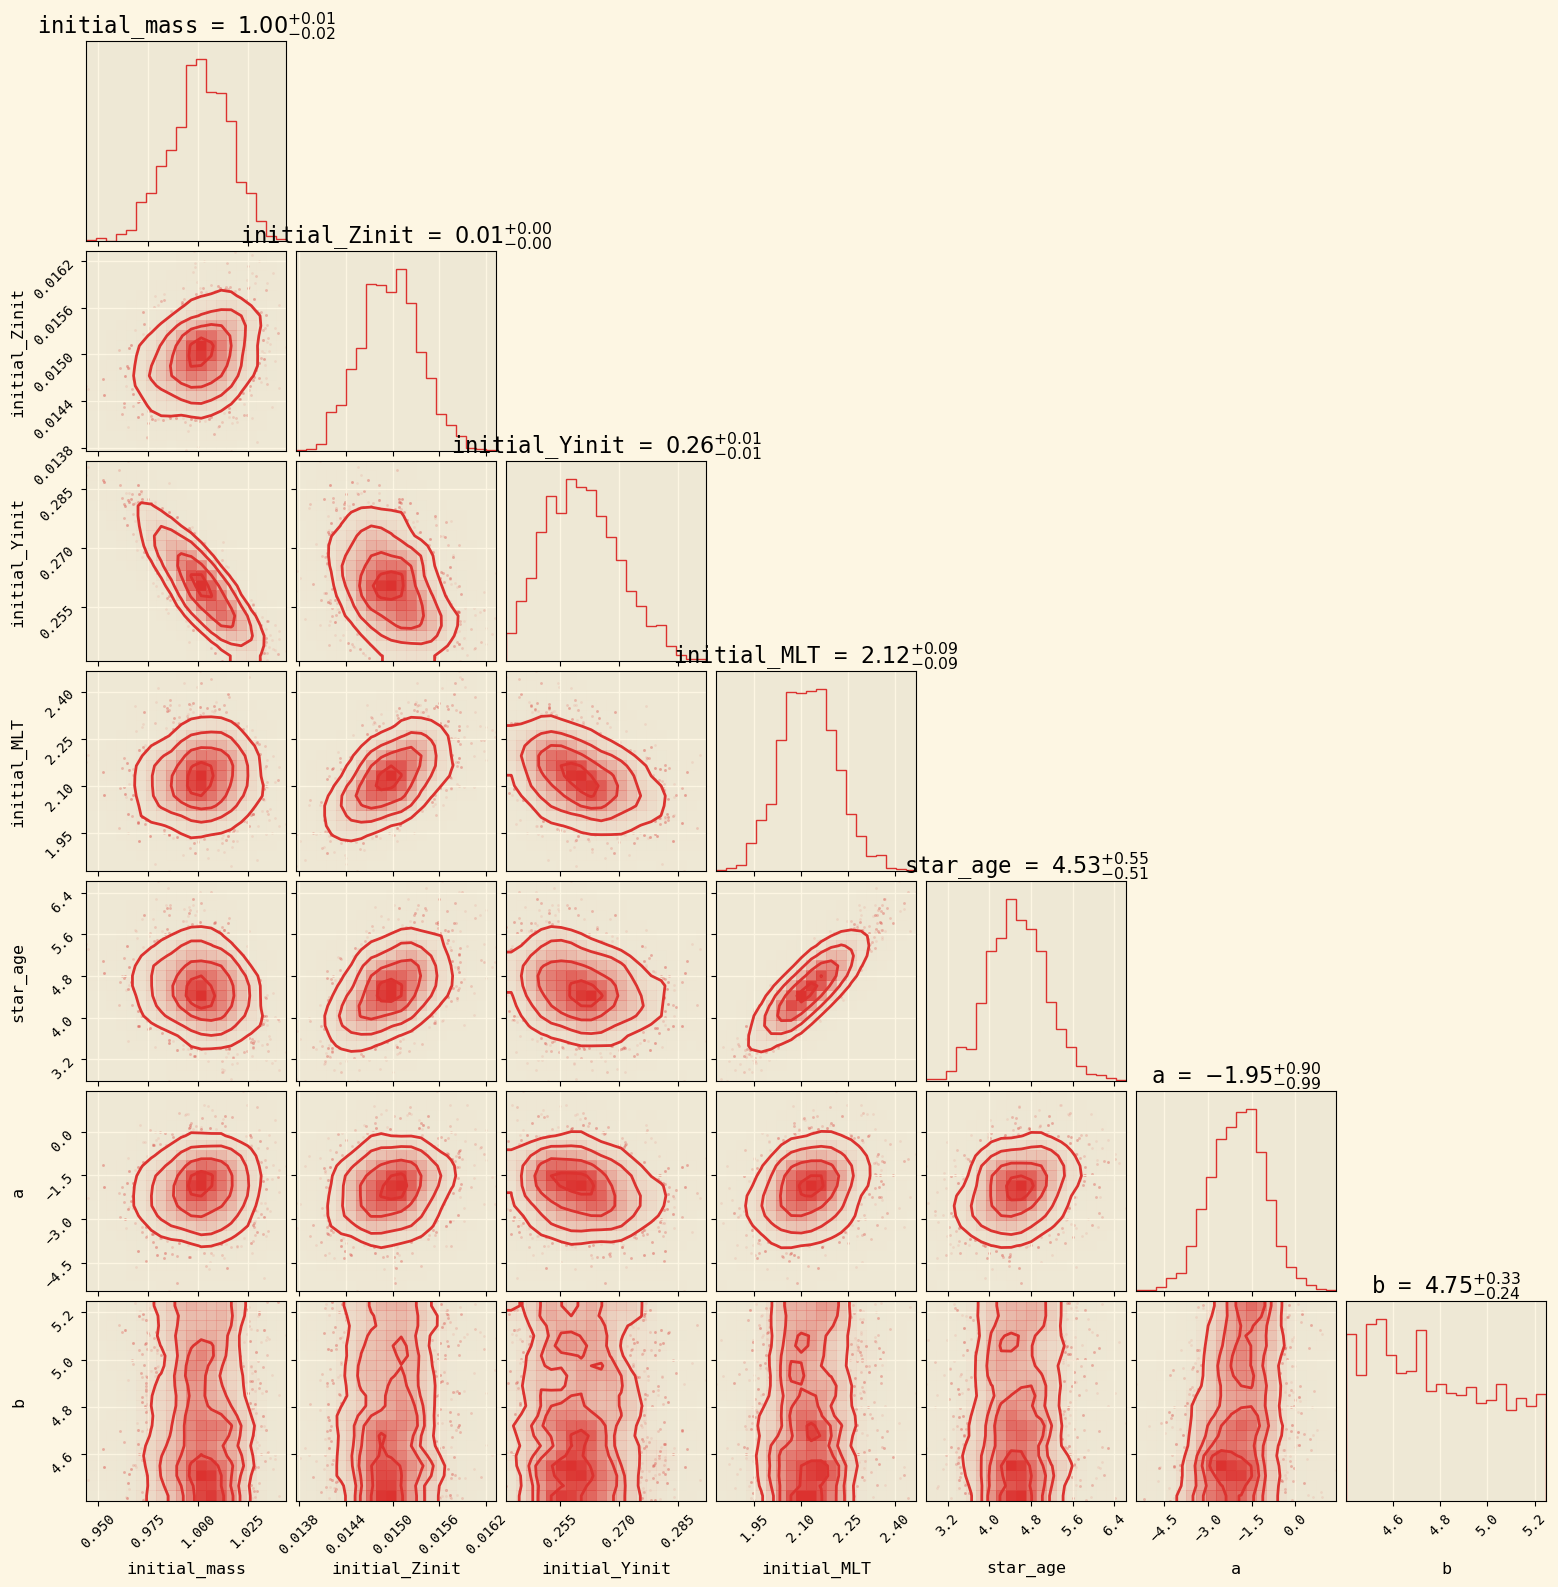

In [62]:
posterior_plot(results, include_prior=False);